# Imports

In [1]:
# stdlib
import re
import copy
import random
import itertools
import statistics
import multiprocessing

# data wrangling
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# custom
from hotspot_classes import Hotspot
import hotspot_utils
import mlr_utils

# Set the number of processors to use for parallel processing
n_processors = max([1,multiprocessing.cpu_count()-2])

# Read in the insults list
with open('insults.txt', 'r') as f:
    insults = f.read().splitlines()

# Reading data - Works for single or double file layouts

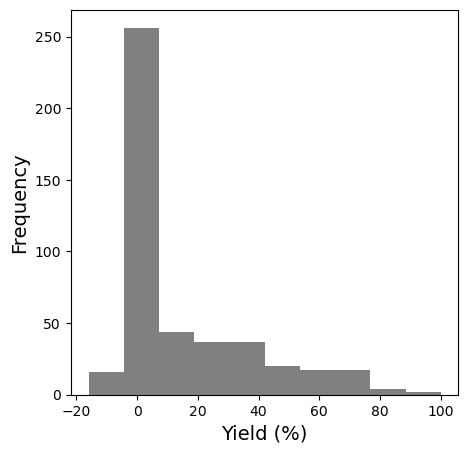

,Yield (%),vmin_vmin_boltz,vmin_r_boltz,fmo_e_homo_boltz,fmo_e_lumo_boltz,fmo_mu_boltz,fmo_eta_boltz,fmo_omega_boltz,somo_ra_boltz,somo_rc_boltz,...,sterimol_burB5_boltz,sterimol_burB5_min,sterimol_burB5_max,sterimol_burB5_delta,sterimol_burB5_vburminconf,sterimol_burL_boltz,sterimol_burL_min,sterimol_burL_max,sterimol_burL_delta,sterimol_burL_vburminconf
Reaction_ID,,,,,,,,,,,,,,,,,,,,,
R1_2,1.916534,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,-0.345264,...,6.572514,6.339063,7.850955,1.511892,6.407769,7.285463,6.908743,8.216943,1.308200,7.992698
R1_5,98.000000,-0.061351,1.816461,-0.218842,-0.030145,-0.124494,0.188697,0.041069,0.060353,-0.376125,...,6.497622,6.092458,7.055260,0.962802,6.376705,7.370445,7.021018,8.155038,1.134020,8.086289
R1_6,0.617317,-0.071244,1.780166,-0.209940,0.016420,-0.096760,0.226360,0.020681,0.083040,-0.388780,...,6.443564,6.443564,6.443564,0.000000,6.443564,6.952513,6.952513,6.952513,0.000000,6.952513
R1_8,0.851423,-0.067185,1.780165,-0.216880,0.036010,-0.090435,0.252890,0.016170,0.113990,-0.456130,...,4.894739,4.894739,4.894739,0.000000,4.894739,6.648917,6.648917,6.648917,0.000000,6.648917
R1_10,4.908090,-0.067275,1.781649,-0.217025,0.020780,-0.098122,0.237805,0.020244,0.090149,-0.396203,...,6.615313,6.374532,7.124679,0.750147,6.377288,7.056268,7.037797,7.146163,0.108366,7.099058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R5_796,-13.206800,-0.024164,1.903453,-0.257967,-0.078693,-0.168330,0.179275,0.079036,0.006817,-0.407675,...,6.954069,6.028940,7.391170,1.362230,6.086104,6.989464,6.925771,7.430007,0.504236,7.430007
R5_797,-12.784600,-0.024191,1.900147,-0.256970,-0.079570,-0.168270,0.177400,0.079805,0.011430,-0.415940,...,6.027940,6.027940,6.029321,0.001381,6.029321,6.909132,6.909131,6.918910,0.009778,6.918910
R5_798,-13.645200,-0.026401,1.900154,-0.254050,-0.079880,-0.166965,0.174170,0.080029,0.005780,-0.411720,...,6.034069,6.029424,6.034070,0.004646,6.034070,6.910345,6.910344,6.919218,0.008874,6.910344


In [2]:
# This cell assumes that your spreadsheets are in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.
# Check cell outputs to make sure everything looks good

parameters_file = "Multi-Threshold Analysis Data" # Excel file to pull parameters from
parameters_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull parameters from
parameters_start_col = 2   # 0-indexed column number where the parameters start
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Multi-Threshold Analysis Data" # Excel file to pull responses from
response_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull responses from
response_col = 1 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 0 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield (%)" # Name of your response variable

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.rename(columns = {data_df.columns.values[0]: RESPONSE_LABEL}, inplace = True) # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # Remove any rows with blanks

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Get a list of all the features
all_features = list(data_df.columns)
all_features.remove(RESPONSE_LABEL)

# Check for duplicate reaction labels or column names
error = False
if len(list(data_df.index)) != len(list(set(data_df.index))):
    print('THERE ARE DUPLICATE REACTION LABELS IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True
if len(list(data_df.columns)) != len(list(set(data_df.columns))):
    print('THERE ARE DUPLICATE COLUMN NAMES IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True

if not error:
    # Print out the data distribution of the response variable
    plt.figure(figsize=(5, 5))
    plt.hist(data_df[RESPONSE_LABEL], color='grey')
    plt.xlabel(RESPONSE_LABEL, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

    # Display the dataframe
    display(data_df)

# Basic visualization

## Histograms and univariate correlations

In [ ]:
# {features} should be a list of feature names or column numbers you want to get the distribution and correlation for
features = all_features # Cycles through all features
# features = list(range(4,16)) + [27, 32] # Cycles through a specific set of features by column number
# features = ['vbur_vbur_min', 'vmin_vmin_boltz'] # Cycles through a specific set of features by name

r2_cutoff = 0.3 # R^2 cutoff for correlation below which the feature will be skipped

# This feels like a relic of a bygone era, but here it is. 'matplotlib' refers to what was once the 'OG' cell.
visualization_type = 'seaborn' # 'matplotlib' or 'seaborn'

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Convert all features to column names
features = mlr_utils.process_features(features, data_df)
print(features)

anything = False
for feature in features:
    print(feature)

    # If the feature has no variance it would break the math later on, so we skip it
    if data_df[feature].std() == 0:
        print("No variance in feature. Skipping.")
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature], data_df[RESPONSE_LABEL])
    fit_line = intercept+slope*data_df[feature]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        continue

    plt.figure(figsize=(9, 4))
    
    # Plot feature distribution
    plt.subplot(1,2,1)
    plt.hist(data_df[feature], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot univariate correlation
    plt.subplot(1,2,2)

    if visualization_type == 'matplotlib':
        plt.scatter(data_df[feature], data_df[RESPONSE_LABEL],color="black",marker="s",alpha=0.5)    
        plt.plot(data_df[feature],fit_line,color="black")
    elif visualization_type == 'seaborn':
        sns.set_style("white")
        sns.regplot(x=data_df[feature],y=data_df[RESPONSE_LABEL],ci=95,truncate=False)
        x_max=np.max(data_df[feature])
        x_min=np.min(data_df[feature])
        y_max=np.max(data_df[RESPONSE_LABEL])
        y_min=np.min(data_df[RESPONSE_LABEL])
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
    else:
        print(f'Invalid visualization type: {visualization_type}. Please fix and try again.')
        break

    plt.xlabel(f'{feature}',fontsize=15)
    plt.ylabel(RESPONSE_LABEL,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    plt.tight_layout()
    plt.show()  
    anything = True  

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n") 

if anything:
    print('At least one result!') 
else:
    print('No results!') 

## Plot a feature vs. another feature

In [ ]:
# {features_1} and {features_2} are the features you want to get the correlation for
# Set them to all_features to get the correlation for all features, or specify a list of features by name or column number to compare

features_1 = all_features
features_2 = all_features

# features_1 = list(range(4,16)) + [27, 32] # Cycles through a specific set of features by column number
# features_2 = ['vbur_vbur_min', 'vmin_vmin_boltz'] # Cycles through a specific set of features by name

r2_cutoff = 0.3 # R^2 cutoff for correlation below which the feature pair will be skipped

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Convert all features to column names
features_1 = mlr_utils.process_features(features_1, data_df)
features_2 = mlr_utils.process_features(features_2, data_df)

for feature_1,feature_2 in itertools.product(features_1, features_2):
    # No use wasting time comparing a feature to itself
    if feature_1 == feature_2:
        continue

    print(f'{feature_1} - {feature_2}')

    # If either feature has no variance it would break the math later on, so we skip it
    if data_df[feature_1].std() == 0 or data_df[feature_2].std() == 0:
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature_1], data_df[feature_2])
    fit_line = intercept+slope*data_df[feature_1]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        print("\n-------------------------------------------------------------------------------\n")
        continue
    
    # Print p-values and R^2 values
    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

    plt.figure(figsize=(16, 4))

    # Plot feature 1 distribution
    plt.subplot(1,3,1)
    plt.hist(data_df[feature_1], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(feature_1,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot feature 2 distribution
    plt.subplot(1,3,2)
    plt.hist(data_df[feature_2], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(feature_2,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot bivariate correlation
    plt.subplot(1,3,3)
    sns.set_style("white")
    sns.scatterplot(x=data_df[feature_1], y=data_df[feature_2], hue=data_df[RESPONSE_LABEL], palette="viridis")
    sns.regplot(x=data_df[feature_1],y=data_df[feature_2],scatter=False,truncate=False)

    x_max=np.max(data_df[feature_1])
    x_min=np.min(data_df[feature_1])
    y_max=np.max(data_df[feature_2])
    y_min=np.min(data_df[feature_2])
    delta_x = 0.05 * (x_max-x_min)
    delta_y = 0.05 * (y_max-y_min)
    plt.xlim([x_min-delta_x,x_max+delta_x])
    plt.ylim([y_min-delta_y,y_max+delta_y])

    plt.xlabel(feature_1,fontsize=15)
    plt.ylabel(feature_2,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    # Show the plots
    plt.tight_layout()
    plt.show()
    print("\n-------------------------------------------------------------------------------\n")
    

## Correlation Map

In [ ]:
# Run to see how correlated the features are with each other

corrmap = data_df.corr()

plt.subplots(figsize=(15,15))
sns.heatmap(corrmap,center=0, annot=False, cmap="coolwarm", cbar=True) #linewidths=0.5
plt.xticks(range(len(all_features)),all_features, fontsize=5, rotation=90)
plt.yticks(range(len(all_features)),all_features, fontsize=5)
plt.show()

# Threshold Analysis

## Train/Validation/Test split

In [ ]:
# Split options are 'random', 'ks', 'y_equidistant', 'stratified', 'define', 'none'

# Core options
split = "stratified"
validation_ratio = 0.2

# Test set options
use_test = True
test_ratio = 0.2

# Less common parameters
stratified_quantiles = 8 # Number of quantiles to split the data into for stratified sampling
defined_training_set = [] # If you want to manually define the training set, put the list of points here
defined_validation_set = [] # If you want to manually define the validation set, put the list of points here
defined_test_set = [] # If you want to manually define the test set, put the list of points here
randomstate = 42 # Random state for reproducibility

# If you get 'ValueError: The least populated class in y has only 1 member...', decrease the number of stratified_quantiles

# --------------------------------------------------------------------------------------------------------------

training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, validation_ratio, test_ratio, all_features, RESPONSE_LABEL, use_test,
                                                        defined_test_set=defined_test_set, defined_training_set=defined_training_set, defined_validation_set=defined_validation_set,
                                                        randomstate=randomstate, stratified_quantiles=stratified_quantiles)

## Automatic Threshold Analysis

In [ ]:
# Cutoff in your output for what counts as an active ligand
y_cut = 10

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:10, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# How many threshold dimensions do you want?
n_thresholds = 2

# What percentage of thresholds are analyzed in each subsequent step
percentage = 100

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, all_features)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, validation_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with multiprocessing.Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, itertools.repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

## Manual Threshold Analysis

In [ ]:
# {manual_features} are the features that will be used to build the thresholds
# It should be a list of lists, where each sublist is a set of features that can be selected for that threshold
# You can specify features by name or column number

manual_features = [['vbur_vbur_min'], ['vmin_vmin_boltz']] # This will create a double threshold with these three features
# manual_features = [[1], list(range(85,91))] # This will make double thresholds with the first feature and each of the features 85 to 90

# Cutoff for what counts as a hit
y_cut = 10

# How heavily to value hits (1) over misses (0)
class_weight = {1:10, 0:1} 

# What percentage of hotspots to take through to each subsequent step
# Only relevant if using ranges instead of specific parameters
percentage = 100

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# Set to True if you want a hotspot of low output results (cold spot?)
low_is_good = False

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

# Convert all features to column names
for i, feature_set in enumerate(manual_features):
    manual_features[i] = mlr_utils.process_features(feature_set, hotspot_data_df)

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, manual_features[0])
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, validation_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(len(manual_features) - 1):
    new_hotspots = []
    for hs in best_hotspots:
        temp_hotspots = hotspot_utils.hs_next_thresholds(hs, hotspot_data_df, class_weight, manual_features[i+1])
        new_hotspots.extend(temp_hotspots)
    best_hotspots = new_hotspots
    del (new_hotspots)
    best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)
    
best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)
# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

## Visualize Thresholds

In [ ]:
# For more direct control over plot style, changes can be made to the plotting functions in hotsput_utils.py
# One of the above functions must be run before this cell can ran
hotspot_index =  0
print(best_hotspots[hotspot_index])

# subset can be 'all', 'training', or 'test'
# You can change the coloring to either 'scaled' or 'binary'
hotspot_utils.plot_hotspot(best_hotspots[hotspot_index], 
                            subset='all', 
                            coloring='binary', 
                            output_label=RESPONSE_LABEL, 
                            gradient_color='Oranges')

# Data preparation: Training/Validation/Test set split, Scaling

## Filter data before train/validation/test split

In [ ]:
# If you want to go forward with only data from the active space of a (multi)threshold, run this cell
# Select which hotspot you want to use based on the index from the Threshold Analysis section

hotspot_index = 0

# --------------------------------------------------------------------------------------------------------------

points_to_keep = best_hotspots[hotspot_index].get_hotspot_space()

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

In [ ]:
# If you want to use a custom cutoff in a certain parameter to limit which points you take forward, run this cell
# Set keep_points_below_cutoff to True if you want to keep points below the cutoff, False if you want to keep points above

cutoff_feature = 'vbur_vbur_min'
cutoff_value = 57.277
keep_points_below_cutoff = True

# --------------------------------------------------------------------------------------------------------------

points_to_keep = data_df.index.to_list()

for i in data_df.index:
    if keep_points_below_cutoff:
        if data_df.loc[i, cutoff_feature] > cutoff_value:
            points_to_keep.remove(i)
    else:
        if data_df.loc[i, cutoff_feature] < cutoff_value:
            points_to_keep.remove(i)

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

In [ ]:
# If you want to exclude specific points from training, validation, and test sets, run this cell
# Points are excluded by their index label

points_to_exclude = ['R1_186']

# --------------------------------------------------------------------------------------------------------------

points_to_keep = [point for point in data_df.index if point not in points_to_exclude]

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

## Train/Validation/Test Set Split

Training Set: ['R1_2', 'R1_11', 'R1_30', 'R1_32', 'R1_44', 'R1_64', 'R1_65', 'R1_68', 'R1_70', 'R1_79', 'R1_88', 'R1_103', 'R1_104', 'R1_117', 'R1_133', 'R1_137', 'R1_157', 'R1_159', 'R1_162', 'R1_163', 'R1_165', 'R1_168', 'R1_171', 'R1_175', 'R1_182', 'R1_184', 'R1_186', 'R1_187', 'R1_196', 'R1_239', 'R1_249', 'R1_252', 'R1_260', 'R1_276', 'R1_281', 'R1_296', 'R1_299', 'R1_309', 'R1_310', 'R1_320', 'R1_323', 'R1_337', 'R1_340', 'R1_344', 'R1_487', 'R1_566', 'R1_608', 'R1_739', 'R1_795', 'R1_799', 'R1_838', 'R2_5', 'R2_8', 'R2_10', 'R2_14', 'R2_20', 'R2_21', 'R2_22', 'R2_44', 'R2_53', 'R2_64', 'R2_65', 'R2_68', 'R2_70', 'R2_79', 'R2_82', 'R2_88', 'R2_90', 'R2_117', 'R2_133', 'R2_158', 'R2_162', 'R2_169', 'R2_171', 'R2_175', 'R2_179', 'R2_185', 'R2_186', 'R2_187', 'R2_196', 'R2_233', 'R2_239', 'R2_243', 'R2_249', 'R2_251', 'R2_260', 'R2_266', 'R2_276', 'R2_277', 'R2_292', 'R2_309', 'R2_311', 'R2_337', 'R2_340', 'R2_344', 'R2_608', 'R2_795', 'R2_799', 'R3_2', 'R3_8', 'R3_10', 'R3_11', 'R

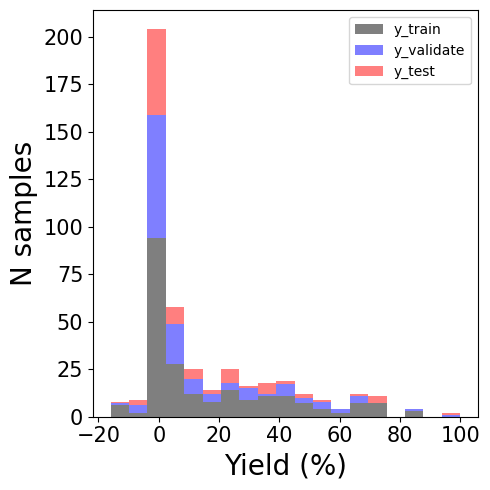

In [3]:
# Split options are 'random', 'ks', 'y_equidistant', 'stratified', 'define', 'none'
# If you want to pull the train, validation, and test sets from only the subset of your data defined above, set use_filtering to True

# Core options
split = "ks"
validation_ratio = 0.3 

# Test set options
use_test = True
test_ratio = 0.2

# Some flags
use_filtering = False
use_scaling = True

# Less common parameters
stratified_quantiles = 8 # Number of quantiles to split the data into for stratified sampling
defined_training_set = [] # If you want to manually define the training set, put the list of points here
defined_validation_set = [] # If you want to manually define the validation set, put the list of points here
defined_test_set = [] # If you want to manually define the test set, put the list of points here
randomstate = 42 # Random state for reproducibility

# --------------------------------------------------------------------------------------------------------------

if use_filtering:
    training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, validation_ratio, test_ratio, all_features, RESPONSE_LABEL, use_test,
                                                            defined_test_set=defined_test_set, defined_training_set=defined_training_set, defined_validation_set=defined_validation_set,
                                                            randomstate=randomstate, stratified_quantiles=stratified_quantiles, subset=points_to_keep)
else:
    training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, validation_ratio, test_ratio, all_features, RESPONSE_LABEL, use_test,
                                                            defined_test_set=defined_test_set, defined_training_set=defined_training_set, defined_validation_set=defined_validation_set,
                                                            randomstate=randomstate, stratified_quantiles=stratified_quantiles)

if use_scaling:
    # Scales the parameters then puts them into modeling_data_df
    scaler = StandardScaler() # If you want to use a different scaler, change this line

    scaler.fit(data_df.loc[training_set, :])
    modeling_data = scaler.transform(data_df)
    modeling_data_df = pd.DataFrame(modeling_data, index = data_df.index, columns = data_df.columns)
    modeling_data_df[RESPONSE_LABEL] = data_df[RESPONSE_LABEL]
else:
    modeling_data_df = data_df

# Linear modelling - MLR

## Manual Feature Selection


Split method: ks
Validation ratio: 0.3
Used scaling: True

Parameters:
   16.0967 +
   -2.1634 * fmo_e_lumo_boltz
    4.1738 * qpoletens_xx_delta
    8.5869 * qpoletens_zz_min

Training R2  = 0.040
Training Q2  = 0.016
Training MAE = 18.459
Training RMSE = 22.476
Training K-fold R2 = 0.015 (+/- 0.000)

Validation R2      = 0.082
Validation MAE     = 16.822
Validation RMSE    = 20.811

You'd have a better fit if you threw darts to plot the points


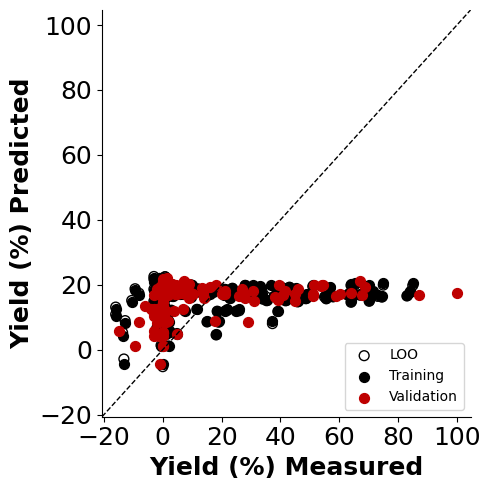

In [4]:
# {features_selected} should be a list of features (names or column numbers) to include in the model

features_selected = [4, 64, 72]
# features_selected = ['vbur_vbur_min', 'vmin_vmin_boltz']

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...) BELOW
# --------------------------------------------------------------------------------------------------------------

features_selected = mlr_utils.process_features(features_selected, modeling_data_df)

# Break up the train/validate data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

# Set up MLR and predict train/validate
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
try:
    y_predictions_validate =  lr.predict(x_validate)
except ValueError as e:
    print(f'Error: {e}')
    print('This cell is not currently equiped to handle modeling without a validation set.')
    raise mlr_utils.StopExecution

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Set up the results dataframe
columns = ['Model', 'n_terms', 'R^2', 'Q^2', 'Validation R^2']
results = pd.DataFrame(columns = columns)
results.loc[0] = [tuple(features_selected), len(features_selected), lr.score(x_train, y_train), q2, mlr_utils.external_r2(y_validate,y_predictions_validate,y_train)]

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio}")
print(f'Used scaling: {use_scaling}')

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(features_selected):
    print(f'{lr.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train, y_predictions_train):.3f}")
print(f'Training RMSE = {np.sqrt(metrics.mean_squared_error(y_train, y_predictions_train)):.3f}')
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nValidation R2      = {mlr_utils.external_r2(y_validate,y_predictions_validate,y_train):.3f}")
print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')
print(f'Validation RMSE    = {np.sqrt(metrics.mean_squared_error(y_validate,y_predictions_validate)):.3f}')

# Print an insult if necessary
train_r2 = lr.score(x_train, y_train)
validation_r2 = lr.score(x_validate, y_validate)
if train_r2 - validation_r2 > 0.35 or train_r2 < 0.4 or validation_r2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))

# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, output_label=RESPONSE_LABEL, plot_xy=True)

## Automatic Feature Selection

Starting 1 parameter models. Total time taken (sec): 0.01
Starting 2 parameter models. Total time taken (sec): 4.12
Starting 3 parameter models. Total time taken (sec): 51.29
	Finished running all 3 parameter models. Time taken (sec): 8.23
	Finished identifying best and unique models. Time taken (sec): 68.10
	Finished backwards step and filtering. Time taken (sec): 151.69
Done. Time taken (minutes): 4.66

Split method: ks
Validation ratio: 0.3

Parameters:
   16.0967 +
   12.4939 * somo_ra_boltz
   22.0866 * sterimol_burB5_min
  -13.6927 * vbur_ovbur_max_vburminconf

Training R2  = 0.445
Training Q2  = 0.430
Training MAE = 12.792
Training K-fold R2 = 0.429 (+/- 0.000)

Validation R2      = 0.309
Validation MAE     = 13.457


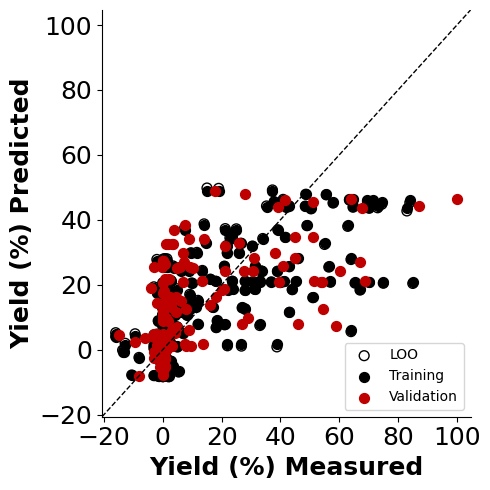

In [4]:
# Bidirectional stepwise selection keeping a set of candidates at each step
n_steps = 3 # This is the maximum number of parameters you want in your models
n_candidates = 50 # This is a measure related to how many models are considered at each step. See mlr_utils.bidirectional_stepwise_regression for more details.
collinearity_cutoff = 0.5 # This is collinearity (r^2) above which parameters won't be included in the same model

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...)
# --------------------------------------------------------------------------------------------------------------

# %notebook inline
plt.ioff()

# This is the function that actually does the MLR model search
results,models,sortedmodels,candidates = mlr_utils.bidirectional_stepwise_regression(modeling_data_df.loc[training_set,:],RESPONSE_LABEL,
                    n_steps=n_steps,n_candidates=n_candidates,collinearity_cutoff=collinearity_cutoff)

# Set up the validation R^2 for each model
for i in results.index:
    model_terms = results.loc[i,"Model"]
    model = models[model_terms].model

    # Set validation R^2 for each model
    x_validate = modeling_data_df.loc[validation_set, model_terms]
    y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]
    validation_r2 = model.score(x_validate, y_validate)
    results.loc[i, 'Validation R^2'] = validation_r2

# Identify the best model from the bidirectional_stepwise_regression algorithm
selected_model_terms = results.loc[0, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/validate data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

# Predict the train and validate sets with the model
y_predictions_train = selected_model.predict(x_train)
try:
    y_predictions_validate =  selected_model.predict(x_validate)
except ValueError as e:
    print(f'Error: {e}')
    print('This cell is not currently equiped to handle modeling without a validation set.')
    raise mlr_utils.StopExecution

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio}")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nValidation R2      = {mlr_utils.external_r2(y_validate,y_predictions_validate,y_train):.3f}")
print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')

# Print an insult if necessary
train_r2 = selected_model.score(x_train, y_train)
validation_r2 = selected_model.score(x_validate, y_validate)
if train_r2 - validation_r2 > 0.35 or train_r2 < 0.4 or validation_r2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, output_label=RESPONSE_LABEL, plot_xy=True)

## Model Visualization

### Filter and View Multiple Models

In [7]:
# How many terms do you want in the largest model?
max_terms = 6
# What column to sort by? ('R^2', 'Q^2', 'Validation R^2', 'Model Quality')
sort_column = 'Validation R^2'
# Only show models containing these features. Set to [] to show all models or a list of x# strings to filter.
include_features = [] 

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE 'Model Quality' CALCULATION
# --------------------------------------------------------------------------------------------------------------

for i in results.index:
    model_terms = results.loc[i,"Model"]
    model = models[model_terms].model

    # Set model quality for each model.  This can be changed based on what's important to you.
    model_quality = results.loc[i,'R^2'] * results.loc[i,'Q^2'] * results.loc[i,'Validation R^2']

    # Make sure two negative values don't cancel each other out to give a false positive
    if(results.loc[i,'R^2'] <= 0 or results.loc[i,'Q^2'] <= 0 or results.loc[i,'Validation R^2'] <= 0):
        model_quality = -abs(model_quality)
    results.loc[i,'Model Quality'] = model_quality

# Sort and filter results
filtered_results = results[results.n_terms <= max_terms] # Filter out models with too many terms
filtered_results.sort_values(by=[sort_column], ascending=False, inplace=True)
for feature in include_features: # Filter out models that don't contain the specified features
    filtered_results = filtered_results[filtered_results['Model'].apply(lambda x: feature in x)]

pd.set_option('display.width', 1000)
print(filtered_results.head(20)) # Change this number if you want to see more models

                                                 Model  n_terms       R^2       Q^2  Validation R^2  Model Quality
34   (qpoletens_zz_boltz, sterimol_burB5_min, vbur_...        3  0.407308  0.391906        0.328341       0.052412
66   (qpoletens_zz_min, sterimol_burB5_min, vbur_ne...        3  0.394234  0.378007        0.328288       0.048922
65   (qpoletens_zz_min, sterimol_burB5_min, vbur_ne...        3  0.394249  0.378040        0.328164       0.048910
35   (qpoletens_zz_boltz, sterimol_burB5_min, vbur_...        3  0.407242  0.391849        0.328118       0.052360
19   (fmo_omega_boltz, sterimol_burB5_min, vbur_nea...        3  0.417892  0.403052        0.326269       0.054954
18   (fmo_omega_boltz, sterimol_burB5_min, vbur_nea...        3  0.417894  0.403063        0.326111       0.054929
575  (fmo_omega_boltz, sphericity_boltz, vbur_qvtot...        3  0.334977  0.314682        0.320545       0.033789
61   (qpole_amp_boltz, sterimol_burB5_min, vbur_nea...        3  0.395275  0.379

### Display a Specific Model


Split method: ks
Validation ratio: 0.3

Features: ('qpoletens_zz_boltz', 'sphericity_boltz', 'sterimol_burB5_delta')

Parameters:
   16.0967 +
   10.6864 * qpoletens_zz_boltz
  -13.9236 * sphericity_boltz
   -5.5087 * sterimol_burB5_delta

Training R2  = 0.339
Training Q2  = 0.320
Training MAE = 14.626
Training K-fold R2 = 0.318 (+/- 0.000)

Validation R2      = 0.282
Validation MAE     = 14.142

If your models were any worse, they'd predict yesterday's weather.


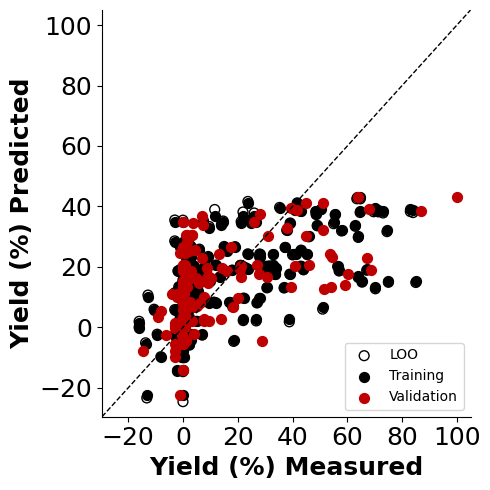

                            OLS Regression Results                            
Dep. Variable:              Yield (%)   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     37.82
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           9.15e-20
Time:                        10:39:49   Log-Likelihood:                -977.51
No. Observations:                 225   AIC:                             1963.
Df Residuals:                     221   BIC:                             1977.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   16.0967 

In [8]:
# Select model to display
model_index = 478

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...)
# --------------------------------------------------------------------------------------------------------------

selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

# Predict the train and validate sets with the model
y_predictions_train = selected_model.predict(x_train)
y_predictions_validate =  selected_model.predict(x_validate)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio}")
print(f"\nFeatures: {selected_model_terms}")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nValidation R2      = {mlr_utils.external_r2(y_validate,y_predictions_validate,y_train):.3f}")
print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')

# Print an insult if necessary
train_r2 = selected_model.score(x_train, y_train)
validation_r2 = selected_model.score(x_validate, y_validate)
if train_r2 - validation_r2 > 0.35 or train_r2 < 0.4 or validation_r2 < 0.2 or q2 < 0:
    print("\n"+random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, output_label=RESPONSE_LABEL, plot_xy=True)

# Print detailed model statistics
stats_model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(stats_model.summary())

# Virtual Screening / Validation

## Import Virtual Screening / Validation Parameter Data

This cell must be executed before any other validation or virtual screening cells

In [ ]:
# This cell assumes that your spreadsheet is in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.

vs_parameters_file = "kraken descriptors" # Excel file to pull parameters from
vs_parameters_sheet = "DFT_data" # Sheet in the Excel file to pull parameters from
vs_parameters_start_col = 1   # 0-indexed column number where the parameters start
vs_parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
vs_parameters_header_rows = 0 # Number of rows to skip when reading the parameters. First row should be parameter names.

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into a dataframe
vs_parameters_df = pd.read_excel("./InputData/" + vs_parameters_file + ".xlsx",
                              vs_parameters_sheet,
                              header = vs_parameters_header_rows,
                              index_col = vs_parameters_y_label_col,
                              )

# Skip any columns that are not parameters
vs_parameters_df = vs_parameters_df.iloc[:,vs_parameters_start_col-1:]

# Check that all parameters from the original dataset are present and put them in the same order
try:
  vs_parameters_df = vs_parameters_df[all_features]
except KeyError:
  print('There are features in the main dataset that are not present in this parameter file.')
  print('If your model was built with scaled features, this will cause an error downstream.')

  # If any parameters are missing, at least remove all columns that are not in the original dataset
  columns_to_keep = [col for col in vs_parameters_df.columns if col in all_features]
  vs_parameters_df = vs_parameters_df[columns_to_keep]

# Display the dataframe
display(vs_parameters_df)

## Validation

In [ ]:
# Run this cell before the specific validation cells to set up the validation dataframe
# Read the validation results from the excel sheet
# The final result should be a dataframe with indicies corresponding to the vs_parameters_df from above,
# a column of experimental outputs, and all the relevant parameters

validation_file = "Multi-Threshold Analysis Data" # Excel file to pull validation results from
validation_sheet = "Reaction II Validation" # Sheet in the Excel file to pull validation results from
validation_response_col = 2 # 0-indexed column number for the experimental output
validation_y_label_col = 0  # 0-indexed column number where the ligand labels are
validation_header_rows = 0 # Number of rows to skip when reading the responses

############################################################################################################

vs_response_df = pd.read_excel('./InputData/' + validation_file + '.xlsx',
                              sheet_name=validation_sheet,
                              header=validation_header_rows,
                              index_col=validation_y_label_col
                              )

# Drop all columns except the experimental output
vs_response_df = vs_response_df.iloc[:, [validation_response_col-1]]
vs_response_df.columns = [RESPONSE_LABEL]

for column in vs_response_df.columns:
    vs_response_df[column] = pd.to_numeric(vs_response_df[column], errors='coerce')
vs_response_df.dropna(inplace = True)

vs_combined_df = pd.concat([vs_response_df, vs_parameters_df], axis=1, join='inner')

display(vs_combined_df)

### MLR Validation

In [ ]:
# Select model to validate
model_index = 21

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Scales the parameters if scaling was used in the train/test split cell
if use_scaling:
    vs_modeling_data = scaler.transform(vs_combined_df)
    vs_modeling_data_df = pd.DataFrame(vs_modeling_data, index = vs_combined_df.index, columns = vs_combined_df.columns)
    vs_modeling_data_df[RESPONSE_LABEL] = vs_combined_df[RESPONSE_LABEL]
else:
    vs_modeling_data_df = vs_combined_df

# Select the model to use
selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

x_validate = vs_modeling_data_df.loc[:, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the validation set
y_validate = vs_modeling_data_df.loc[:, RESPONSE_LABEL]

# Set up MLR and predict train/test
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
if len(x_test) > 0: # In case there is no test set
    y_predictions_test =  lr.predict(x_test)
y_predictions_validate = lr.predict(x_validate)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{lr.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

if len(x_test) > 0: # In case there is no test set
    print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
    print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

print(f"\nValidation R2      = {mlr_utils.external_r2(y_validate,y_predictions_validate,y_train):.3f}")
print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')

# Print an insult if necessary
if len(x_test) > 0: # In case there is no test set
    train_r2 = lr.score(x_train, y_train)
    test_r2 = lr.score(x_test, y_test)
    if train_r2 - test_r2 > 0.35 or train_r2 < 0.4 or test_r2 < 0.2 or q2 < 0:
        print("\n" + random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_test, y_predictions_test, loo_train, y_predictions_validate=y_predictions_validate, y_validate=y_validate, output_label=RESPONSE_LABEL, plot_xy=False)

### Threshold Validation

In [ ]:
# Select hotspot to validate
hotspot_index = 0

# Set to True if you want to see only the virtual screen results plotted
hide_training = False

save_evaluation = False # Set to True if you want to save the threshold evaluation to an Excel file in the OutputData folder
save_filename = "threshold_evaluation" # Name of the Excel file to save the threshold evaluation to if save_evaluation is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(vs_combined_df)

# Get validation stats and display the hotspot
hs.get_external_accuracy(vs_combined_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, vs_combined_df, vs_parameters_df, coloring='binary', output_label=RESPONSE_LABEL, hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)

# Save the threshold evaluations to an Excel file if requested
if save_evaluation:
    threshold_evaluations.to_excel("./OutputData/" + save_filename + ".xlsx")

## Virtual Screening

### MLR Virtual Screening

In [ ]:
# Predict the outputs for all datapoints in your library read in in the Import Virtaul Screening Data section
# Uses the train/test split defined in the Data Preparation section, so you can reset it there if you want to predict without a split

model_index = 21 # Index of the model you want to predict the validation set with

save_predictions = False # Set to True if you want to save the predictions to an Excel file in the OutputData folder
save_filename = "mlr_predictions" # Name of the Excel file to save the predictions to if save_predictions is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Scales the parameters if scaling was used in the train/test split cell
if use_scaling:
    dummy_column = pd.DataFrame({RESPONSE_LABEL: [0] * len(vs_parameters_df)}, index=vs_parameters_df.index)
    vs_modeling_data = pd.concat([dummy_column, vs_parameters_df], axis=1)
    final_index = vs_modeling_data.index
    final_columns = vs_modeling_data.columns
    vs_modeling_data = scaler.transform(vs_modeling_data)
    vs_modeling_data_df = pd.DataFrame(vs_modeling_data, index = final_index, columns = final_columns)
else:
    vs_modeling_data_df = vs_combined_df

# Select the model to use
selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

x_validate = vs_modeling_data_df.loc[:, selected_model_terms] # Dataframe containing just the parameters used in this model for all ligands in the library

# Set up MLR and predict train/test
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
y_predictions_test =  lr.predict(x_test)
y_predictions_validate = lr.predict(x_validate)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{lr.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
train_r2 = lr.score(x_train, y_train)
test_r2 = lr.score(x_test, y_test)
if train_r2 - test_r2 > 0.35 or train_r2 < 0.4 or test_r2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))
    
# Plot the model
print('\nVIRTUAL SCREEN POINTS HAVE NOT BEEN EXPERIMENTALLY TESTED. THIS VISUALIZATION IS ONLY TO SHOW DISTRIBUTION OF PREDICTIONS.')
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_test, y_predictions_test, loo_train, y_predictions_validate=y_predictions_validate, output_label=RESPONSE_LABEL)

if save_predictions:
    validation_predictions_df = pd.DataFrame(y_predictions_validate, index=x_validate.index, columns=['Predicted ' + RESPONSE_LABEL])
    validation_predictions_df.to_excel("./OutputData/" + save_filename + ".xlsx")

### Threshold Virtual Screening

In [ ]:
# Select hotspot to screen against
hotspot_index = 0

# Set to True if you want to see only the virtual screen results plotted
hide_training = True

save_predictions = False # Set to True if you want to save the predictions to an Excel file in the OutputData folder
save_filename = "Threshold_VS_Predictions" # Name of the Excel file to save the predictions to if save_predictions is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Trim down to the parameter values relevant to this hotspot and add binary evaluations from each ligand
# True in an xID column indicates that the ligand is predicted to be active by that threshold
virtual_screen_report_df = vs_parameters_df.loc[:, hs.threshold_features]
# virtual_screen_report_df.columns = [f'{parameter}' for parameter in virtual_screen_report_df.columns]

threshold_evaluations = hs.expand(vs_parameters_df)
threshold_evaluations.columns = [f'{parameter} Active' for parameter in threshold_evaluations.columns]
virtual_screen_report_df = pd.concat([virtual_screen_report_df, threshold_evaluations], axis=1)

# Create a column for the final hotspot evaluation if there is more than a single threshold
if len(hs.thresholds) > 1:
    for ligand in virtual_screen_report_df.index:
        evaluation = all([virtual_screen_report_df.loc[ligand, f'{threshold} Active'] for threshold in hs.threshold_features])
        virtual_screen_report_df.loc[ligand, 'Full Hotspot Evaluation'] = evaluation

display(virtual_screen_report_df)

print('The plot below is meant only to show the distribution of the virtual screen since experimental data has not been supplied')
hotspot_utils.plot_hotspot(hs, vs_parameters=vs_parameters_df, hide_training=hide_training, coloring='binary', output_label=RESPONSE_LABEL, gradient_color='Oranges')

# Save the predictions to an Excel file if requested
if save_predictions:
    virtual_screen_report_df.to_excel("./OutputData/" + save_filename + ".xlsx")